# Clickbait Detector

Through NLP and text classification, this project aims to classify a headline as clickbait or non-clickbait. 

Clickbait refers to an article headline whose purpose is to use sensationalist language to lure in a viewer to click through to a certain webpage.  That webpage typically generates ad revenue on the user's clicks or monitizes the user's activity data. The clickbait article itself is not written with journalistic integrity, research or really any deeper or practical meaning - it is simply a vehicle to grab clicks and activity. 

With the explosion of social media, smartphones and so many people connected to the internet daily, there is no shortage of ‘information' and online objects vying for our attention, but all are not equal. The ease of sharing and reposting on social media has allowed clutter like clickbait to run wild. And the often profitable nature of publishing and capitalizing on clickbait has also given way to the increase in clickbait.

With clickbait becoming increasingly common and, generally considered as a nuisance, I wanted to see if a headline could be classified using machine learning and what that looks like. 

#### Possible Stakeholders: 
This could be implemented on a larger scale - on social media/various websites, as a 'clickbait blocker', and clickbait could be flagged or filtered out as such.

#### The Dataset
- 52,000 headlines from clickbait and non-clickbait sources from roughly 2007 - 2020. 
    - 30,000: 2007 - 2016 headlines from https://www.kaggle.com/amananandrai/clickbait-dataset
    - 22,000: 2019 - 2020 headlines that I scraped/requested from Twitter, APIs, online publications. 

Clickbait sources: 
Buzzfeed, Upworthy, ViralNova, BoredPanda, Thatscoop, Viralstories, PoliticalInsider, Examiner, TheOdyssey

Non-clickbait sources: 
NY Times, The Washington Post, The Guardian, Bloomberg, The Hindu, WikiNews, Reuters

## Importing all necessary libraries and packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, recall_score

from sklearn import svm
from sklearn.svm import LinearSVC

from sklearn.dummy import DummyClassifier


from wordcloud import WordCloud, STOPWORDS

import string
from matplotlib import style

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data processing and Feature Engineering

Data cleaning and processing: 
- Punctuation, links and non-alphabetical characters were removed prior to EDA & Modeling. Numbers were left as clickbait headlines appear to use numbers frequently. 
- English stopwords were removed. 
- Each headline was tokenized (unigrams for initial EDA, unigrams & bigrams for modeling and further EDA) and all words were lowercased. 
- For modeling, TFIDF scores were accessed for each unigram and bigram.

Feature Engineering (by hand): 
- headline_words: word count in a headline (before stopwords were removed).
- question: 1 for yes & 0 for no, if the headline started with a question word and/or included a ? (before stopwords and punctuation were removed).
- exclamation: 1 if the headline includes an exclamation point, 0 if it does not (before punctuation was removed).
- starts_with_num: 1 if the headline starts with a number, 0 if it does not. 


## EDA
- Visualizing word frequency for each class.
- Visualizing distribution of engineered features and their relevance on each class.
- Target distribution is mostly balanced.

In [33]:
df = pd.read_csv('with_engineeredfeat_data.csv',index_col=0)

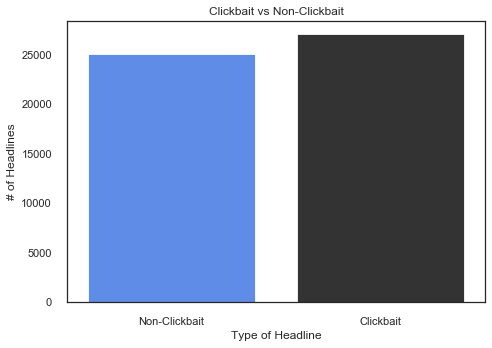

In [71]:
#class variable countplot
#visualizing class frequency of dataset
sns.set_style('white')
plt.figure(figsize=(7,5))
fig1=sns.countplot(df['class'], alpha =.80, palette= ['#1a66ff','black'])
plt.title('Clickbait vs Non-Clickbait')
plt.ylabel('# of Headlines')
plt.xlabel('Type of Headline')
fig1.set(xticklabels=['Non-Clickbait','Clickbait'])
plt.tight_layout()
#plt.savefig('class_dist')
plt.show()


In [5]:
#cleaning data to remove stopwords & tokenize text for EDA

def tokenize(text):
    text = [word_tokenize(x) for x in text]
    return text

df.text = tokenize(df.text)

stopwords_list = stopwords.words('english')
df.text = df['text'].apply(lambda x: [item for item in x if item not in stopwords_list])

In [6]:
#creating seperate dataframes for each class
df_cb=df[df['class']==1]
df_noncb=df[df['class']==0]

#creating a list of unique words for each class
cb_list=list(df_cb['text'])

total_vocab_cb = set()
for word in cb_list:
    total_vocab_cb.update(word)
len(total_vocab_cb)

noncb_list=list(df_noncb['text'])

total_vocab_noncb = set()
for word in noncb_list:
    total_vocab_noncb.update(word)
len(total_vocab_noncb)

flat_cb = [item for sublist in cb_list for item in sublist]
flat_noncb = [item for sublist in noncb_list for item in sublist]


cb_freq = FreqDist(flat_cb)
noncb_freq = FreqDist(flat_noncb)

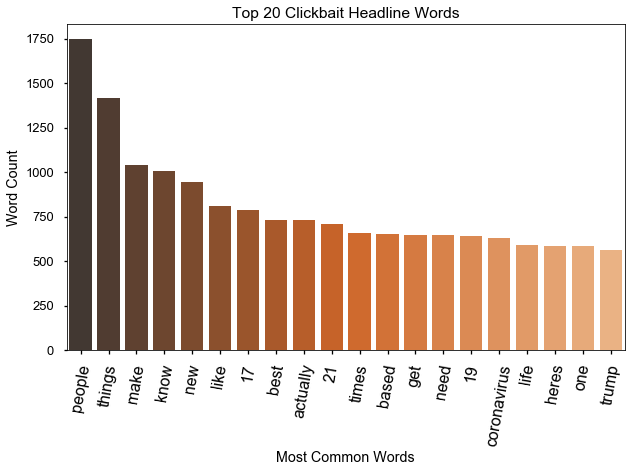

In [7]:
# create counts of clickbait and non-clickbait words and values
cb_bar_counts = [x[1] for x in cb_freq.most_common(20)]
cb_bar_words = [x[0] for x in cb_freq.most_common(20)]

noncb_bar_counts = [x[1] for x in noncb_freq.most_common(20)]
noncb_bar_words = [x[0] for x in noncb_freq.most_common(20)]

plt.style.use('seaborn-talk')

#bar plot for top 15 most common clickbait words
word_freq_figure1 = plt.figure(figsize=(10,6))
sns.barplot(cb_bar_words, cb_bar_counts,palette='Oranges_d')
plt.xticks(fontsize=16)
plt.xticks(rotation=80)
plt.title('Top 20 Clickbait Headline Words')
plt.xlabel('Most Common Words')
plt.ylabel('Word Count')
sns.set_style('white')
plt.savefig('clickbait_20_bar')
plt.show()

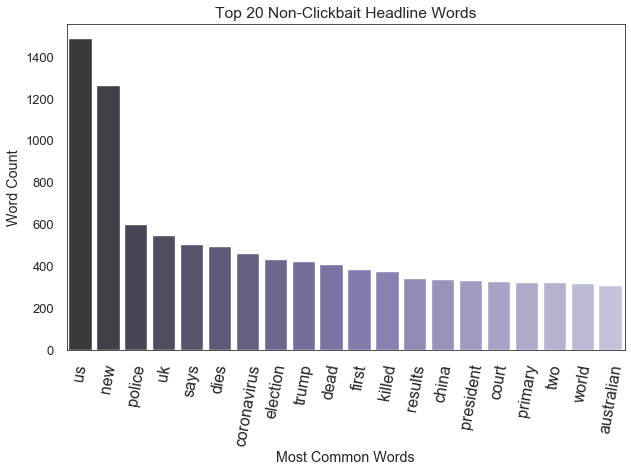

In [8]:
#bar plot for top 15 most common non-clickbait words
word_freq_figure1 = plt.figure(figsize=(10,6))
sns.barplot(noncb_bar_words, noncb_bar_counts,palette='Purples_d')
plt.xticks(fontsize=16)
plt.xticks(rotation=80)
plt.title('Top 20 Non-Clickbait Headline Words')
plt.xlabel('Most Common Words')
plt.ylabel('Word Count')
sns.set_style()
plt.show()

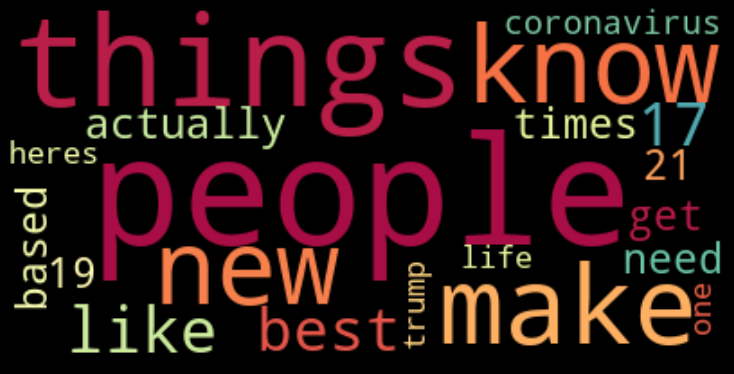

In [18]:
# Getting data into a dictionary
# FORMAT:  dictionary = dict(zip(keys, values))
#!pip install wordcloud
from wordcloud import WordCloud
clickbait_dictionary = dict(zip(cb_bar_words, cb_bar_counts))
nonclickbait_dictionary = dict(zip(noncb_bar_words, noncb_bar_counts))

# Create the clickbait word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(clickbait_dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:

plt.savefig('clickbait_wc')

plt.show()

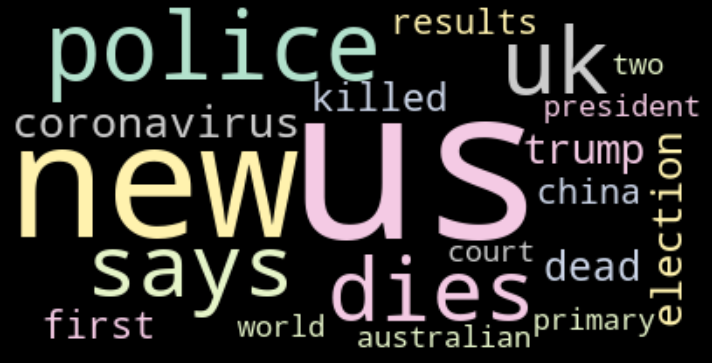

In [15]:
# Create the non-clickbait word cloud:

wordcloud = WordCloud(colormap='Pastel2').generate_from_frequencies(nonclickbait_dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
plt.tight_layout()
plt.savefig('nonclickbait_wc')

plt.show()

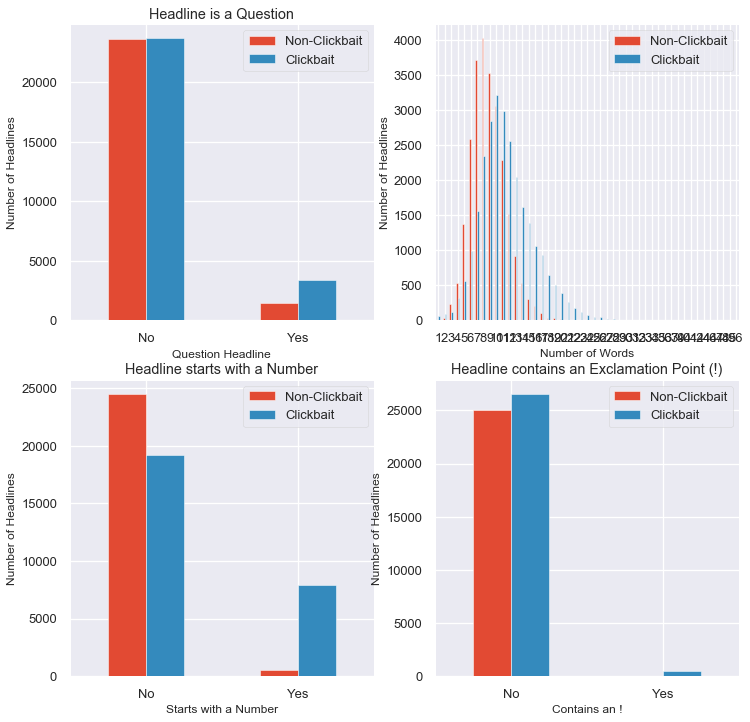

In [20]:
#plotting engineered features to compare by class 
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

plot = df.groupby('question')['class'].value_counts().unstack().plot.bar(ax=axes[0,0], rot=0)
plot.set_xlabel('Question Headline')
plot.set_ylabel('Number of Headlines')
plot.legend(title=None,labels=['Non-Clickbait','Clickbait'])
plot.set(xticklabels=['No','Yes'])
plot.set_title('Headline is a Question')

plot = df.groupby('headline_words')['class'].value_counts().unstack().plot.bar(ax=axes[0,1], rot=0)
plot.set_xlabel('Number of Words')
plot.set_ylabel('Number of Headlines')
plot.legend(title=None,labels=['Non-Clickbait','Clickbait'])


plot = df.groupby('starts_with_num')['class'].value_counts().unstack().plot.bar(ax=axes[1,0], rot=0)
plot.set_xlabel('Starts with a Number')
plot.set_ylabel('Number of Headlines')
plot.legend(title=None,labels=['Non-Clickbait','Clickbait'])
plot.set(xticklabels=['No','Yes'])
plot.set_title('Headline starts with a Number')

plot = df.groupby('exclamation')['class'].value_counts().unstack().plot.bar(ax=axes[1,1], rot=0)
plot.set_xlabel('Contains an !')
plot.set_ylabel('Number of Headlines')
plot.legend(title=None,labels=['Non-Clickbait','Clickbait'])
plot.set(xticklabels=['No','Yes'])
plot.set_title('Headline contains an Exclamation Point (!)')

style.use('ggplot')
plt.show()



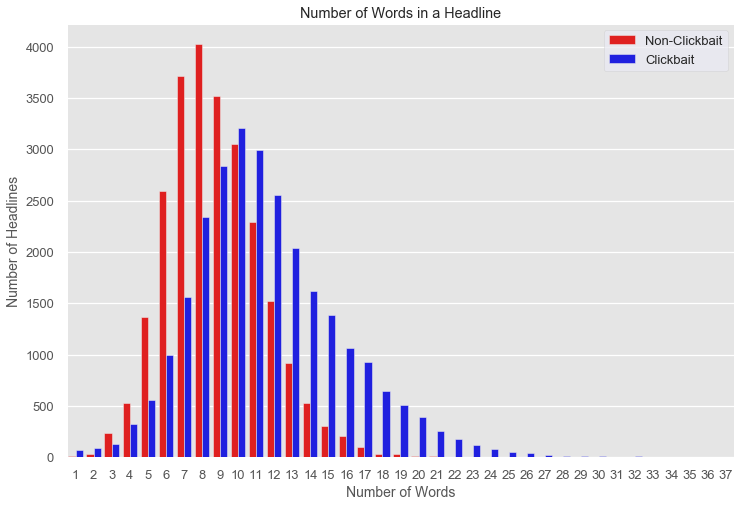

In [21]:
#replotting headline word comparison plot with smaller range

df_words = df[df['headline_words'] < 38]

sns.countplot(df_words['headline_words'],hue=df_words['class'],palette=['red','blue'],data=df_words)
sns.set_style('darkgrid')
plt.xlabel('Number of Words',size=14)
plt.ylabel('Number of Headlines', size=14)
plt.legend(title=None,labels=['Non-Clickbait','Clickbait'],loc='upper right')
plt.title('Number of Words in a Headline')
plt.tight_layout()
plt.savefig('num_words_comparison')

plt.show()

In [31]:
#engineered_feats=df.drop(columns='text')

#engineered_feats.drop(columns='Unnamed: 0',inplace=True)
engineered_feats.corr()

,class,question,exclamation,starts_with_num,headline_words
class,1.000000,0.117118,0.079931,0.366345,0.361940
question,0.117118,1.000000,0.003738,-0.129655,-0.040834
exclamation,0.079931,0.003738,1.000000,-0.038586,0.000258
starts_with_num,0.366345,-0.129655,-0.038586,1.000000,0.015247
headline_words,0.361940,-0.040834,0.000258,0.015247,1.000000


## Modeling
- I will evaluate using accuracy and recall, mostly emphasizing recall to minimize false negatives (labeling an article as not clickbait when it is). 

In [35]:
#reading in cleaned dataframe with engineered features
#will tokenize & remove stopwords with TFIDF
df = pd.read_csv('with_engineeredfeat_data.csv',index_col=0)

In [36]:
df.shape

(52127, 6)

In [39]:
#Create stopwords list
stopwords_list = stopwords.words('english')

#definining y and features
features = df.drop(columns='class')
y = df['class']

#classes are mostly balanced
y.value_counts()

1    27070
0    25057
Name: class, dtype: int64

### Setting up for modeling
- applying TFIDF transformation to headline text
    - vectorizing, tokenizing (unigrams, bigrams)
    - removing stopwords
- train/test split
- creating function for results

In [41]:
#first splitting data for test/train sets 
#ngram range -> unigrams and bigrams 
X_train, X_test, y_train, y_test = train_test_split(features, y, random_state=20)

tfidf = TfidfVectorizer(stop_words = stopwords_list,ngram_range = (1,2))
tfidf_text_train = tfidf.fit_transform(X_train['text'])
tfidf_text_test = tfidf.transform(X_test['text'])

X_train_ef = X_train.drop(columns='text')
X_test_ef = X_test.drop(columns='text')

In [42]:
#combine tf-idf vectors with the engineered features and store as sparse arrays
from scipy import sparse

X_train = sparse.hstack([X_train_ef, tfidf_text_train]).tocsr()
X_test = sparse.hstack([X_test_ef, tfidf_text_test]).tocsr()


In [43]:
print(X_train.shape)
print(X_test.shape)

(39095, 203136)
(13032, 203136)


In [44]:
#creating a function to call after each model iteration to print accuracy and recall scores for test and train
def train_results(preds):
    return "Training Accuracy:", accuracy_score(y_train,preds)," Training Recall:", recall_score(y_train,preds)

def test_results(preds):
    return "Testing Accuracy:", accuracy_score(y_test,preds)," Testing Recall:", recall_score(y_test,preds)

### Dummy Classifier 
- baseline model
- predicts majority class

In [45]:
#baseline model to predict majority class
dc_classifier = DummyClassifier(strategy='most_frequent')

dc_classifier.fit(X_train, y_train)

dc_train_preds = dc_classifier.predict(X_train)
dc_test_preds = dc_classifier.predict(X_test)

print(train_results(dc_train_preds))
print(test_results(dc_test_preds))

('Training Accuracy:', 0.5179946284691137, ' Training Recall:', 1.0)
('Testing Accuracy:', 0.5232504604051565, ' Testing Recall:', 1.0)


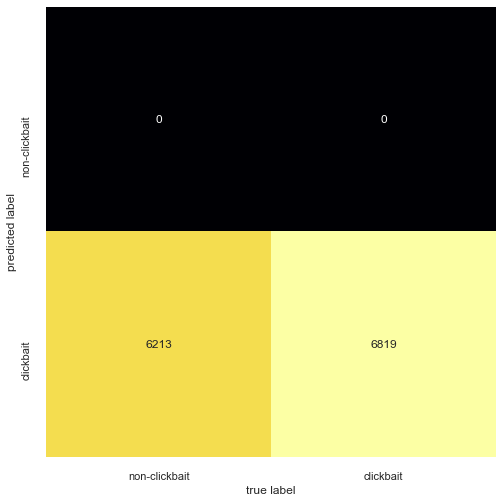

In [69]:
#plot confusion matrix on test set Dummy Classifier
sns.set()

cm_dc = confusion_matrix(y_test, dc_test_preds)
sns.heatmap(cm_dc.T, square=True, annot=True, fmt='d', cbar=False,cmap="inferno", xticklabels=['non-clickbait','clickbait'],yticklabels=['non-clickbait','clickbait']
            )
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.tight_layout()
plt.savefig('dc_cm')

### Naive Bayes
- performs much better than dummy classifier 
- alpha adjusted to maximize accuracy & recall 

In [48]:
nb_classifier = MultinomialNB(alpha = .05)

nb_classifier.fit(X_train, y_train)

nb_train_preds = nb_classifier.predict(X_train)
nb_test_preds = nb_classifier.predict(X_test)

print(train_results(nb_train_preds))
print(test_results(nb_test_preds))

('Training Accuracy:', 0.9986699066376774, ' Training Recall:', 0.9992099155597255)
('Testing Accuracy:', 0.9300184162062615, ' Testing Recall:', 0.9416336706261915)


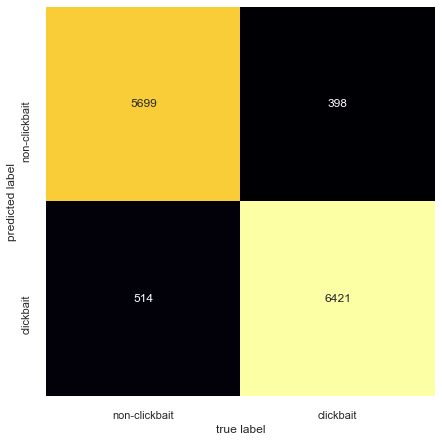

In [51]:
#plot confusion matrix on test set NB Classifier
sns.set()

cm_dc = confusion_matrix(y_test, nb_test_preds)
sns.heatmap(cm_dc.T, square=True, annot=True, fmt='d', cbar=False,cmap="inferno", xticklabels=['non-clickbait','clickbait'],yticklabels=['non-clickbait','clickbait']
            )
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig('nb_cm')
plt.show()

### Random Forest
- overfitting to training set
- tuned via gridsearch 
- accuracy and recall are lower compared to NB

In [52]:
#rf_classifier = RandomForestClassifier(class_weight = 'balanced', n_estimators = 900 )
rf_classifier = RandomForestClassifier(class_weight = 'balanced', n_estimators=900, )
rf_classifier.fit(X_train, y_train)

rf_test_preds = rf_classifier.predict(X_test)
rf_train_preds = rf_classifier.predict(X_train)

print(train_results(rf_train_preds))
print(test_results(rf_test_preds))

('Training Accuracy:', 1.0, ' Training Recall:', 1.0)
('Testing Accuracy:', 0.9074585635359116, ' Testing Recall:', 0.9335679718433788)


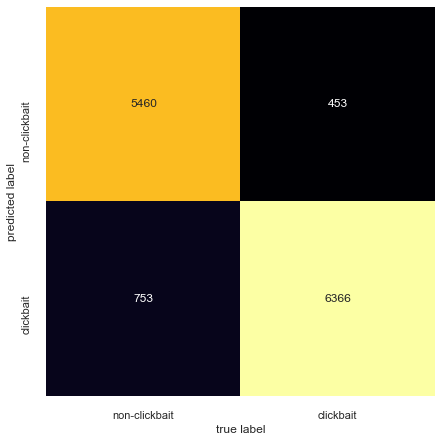

In [53]:
#plot confusion matrix on test set RFC Classifier (no grid search)
sns.set()

cm_dc = confusion_matrix(y_test, rf_test_preds)
sns.heatmap(cm_dc.T, square=True, annot=True, fmt='d', cbar=False,cmap="inferno", xticklabels=['non-clickbait','clickbait'],yticklabels=['non-clickbait','clickbait']
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

### SVM
- linear svc classifier 
- performs better than random forest
- accuracy is slighly better than NB but recall is slighly worse

('Training Accuracy:', 0.999872106407469, ' Training Recall:', 0.9997530986124142)
('Testing Accuracy:', 0.9326273787599755, ' Testing Recall:', 0.9266754656107934)


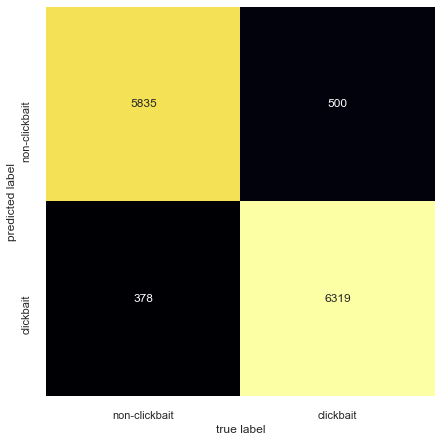

In [54]:
#SVM Model

svm_classifier = LinearSVC(class_weight='balanced', C=10, max_iter = 1500 )

svm_classifier.fit(X_train, y_train)

svm_test_preds = svm_classifier.predict(X_test)
svm_train_preds = svm_classifier.predict(X_train)

print(train_results(svm_train_preds))
print(test_results(svm_test_preds))

#plot confusion matrix on test set SVM Classifier 
sns.set()

cm_dc = confusion_matrix(y_test, svm_test_preds)
sns.heatmap(cm_dc.T, square=True, annot=True, fmt='d', cbar=False,cmap="inferno", xticklabels=['non-clickbait','clickbait'],yticklabels=['non-clickbait','clickbait']
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

### Logistic Regression 
- performance is very close to the SVM metrics
- accuracy is also slightly better than NB but recall is slightly worse


('Training Accuracy:', 0.999872106407469, ' Training Recall:', 0.9997530986124142)
('Testing Accuracy:', 0.9310159607120934, ' Testing Recall:', 0.9241824314415603)


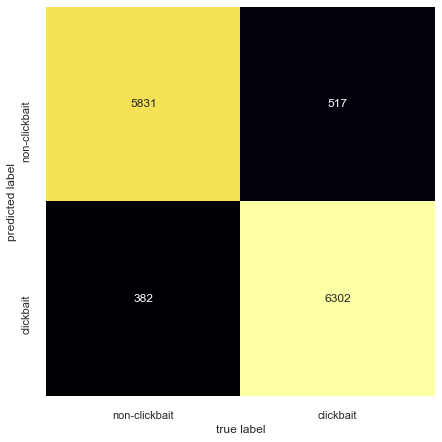

In [70]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=500, class_weight = 'balanced', solver = 'liblinear', tol=0.0001)

lr.fit(X_train,y_train)

lr_train_preds = lr.predict(X_train)
lr_test_preds = lr.predict(X_test)

print(train_results(lr_train_preds))
print(test_results(lr_test_preds))

#plot confusion matrix on test set lr Classifier 
sns.set()

cm_dc = confusion_matrix(y_test, lr_test_preds)
sns.heatmap(cm_dc.T, square=True, annot=True, fmt='d', cbar=False,cmap="inferno", xticklabels=['non-clickbait','clickbait'],yticklabels=['non-clickbait','clickbait']
            )
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.savefig('lr_cm')

### XGBoost 
- running out of box model 
- performs worse out of all other models 


('Testing Accuracy:', 0.8566605279312461, ' Testing Recall:', 0.8558439653908197)
('Training Accuracy:', 0.8834122010487274, ' Training Recall:', 0.8654387437657399)


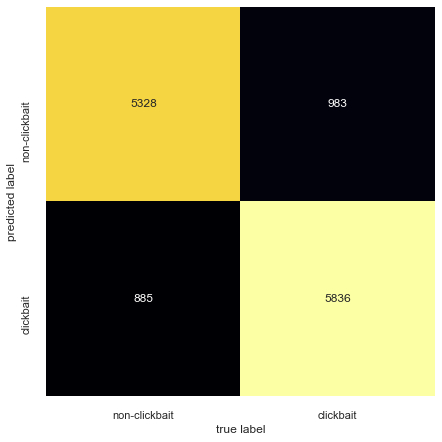

In [56]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
xgb_test_preds = xgb_clf.predict(X_test)
xgb_train_preds = xgb_clf.predict(X_train)

#print(train_results(lr_train_preds))
print(test_results(xgb_test_preds))
print(train_results(xgb_train_preds))

#plot confusion matrix on test set xgboost Classifier 
sns.set()

cm_dc = confusion_matrix(y_test, xgb_test_preds)
sns.heatmap(cm_dc.T, square=True, annot=True, fmt='d', cbar=False,cmap="inferno", xticklabels=['non-clickbait','clickbait'],yticklabels=['non-clickbait','clickbait']
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

### Model Interpretations
- visualize NB coefficients
- visualize SVM coefficients
- visualize Logistic Regression coefficients

In [57]:
#NB coefficients
#creating dataframe for NB coefficients to evaluate the highest/lowest coefficients
coef_nb = pd.DataFrame(nb_classifier.coef_)
#coef_svm.sort_values(by=0,ascending=False).head(20)
coef_df_nb=coef_nb.T

#creating EF name list
engf_name_list=list(X_train_ef.columns)

#creating all feature names list with engineered features and tfidf names
all_feat_names_2 = []

for i in engf_name_list:
    all_feat_names_2.append(i)

for i in tfidf.get_feature_names():
    all_feat_names_2.append(i)
    
#creating column for feat names
coef_df_nb['tokens']=all_feat_names_2

coef_df_nb.set_index('tokens',inplace=True)



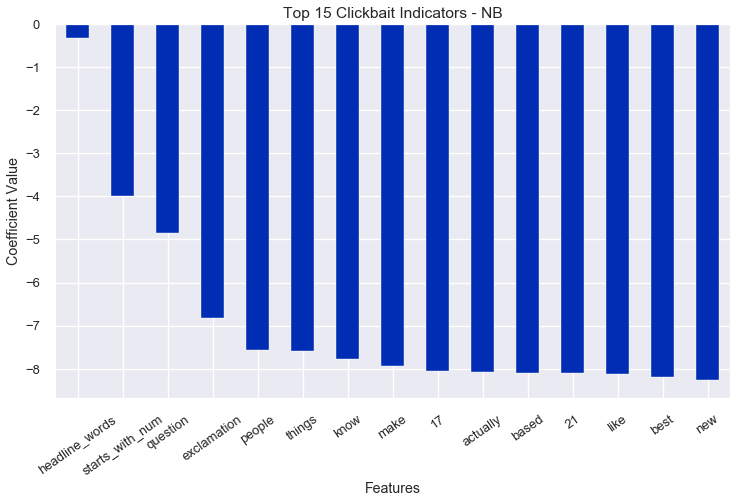

In [68]:
#top 15 coefficients for non-clickbait
plt.style.use('seaborn-talk')

coef_df_nb[0].sort_values(ascending=False).head(15).plot(kind='bar',color='#002db3')
plt.title("Top 15 Clickbait Indicators - NB")
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=35)
plt.tight_layout()
plt.savefig('CB_coefs_nb')
sns.set_style('darkgrid')
plt.show()

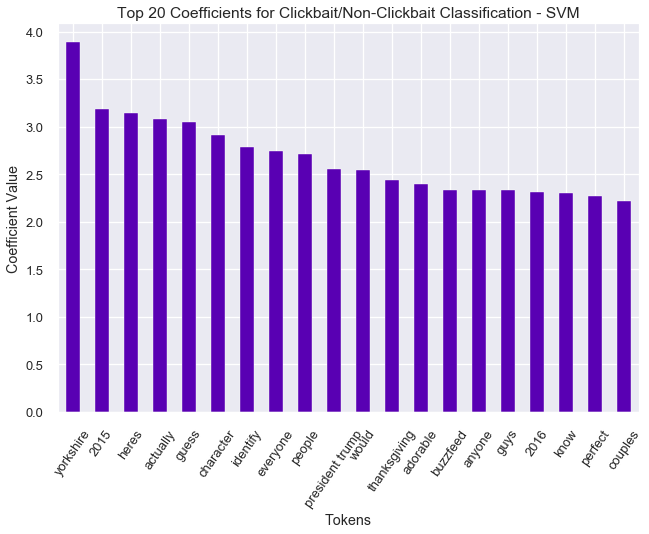

In [64]:
#SVM interpretations 


#svm coefficients
#creating dataframe for SVM coefficients to evaluate the highest coefficients
coef_svm = pd.DataFrame(svm_classifier.coef_)
#coef_svm.sort_values(by=0,ascending=False).head(20)
coef_df_svm=coef_svm.T

coef_df_svm['tokens']=all_feat_names_2
coef_df_svm.set_index('tokens',inplace=True)

coef_df_svm[0].sort_values(ascending=False).head(20).plot(kind='bar',color='#5900b3')
plt.title("Top 20 Coefficients for Clickbait/Non-Clickbait Classification - SVM")
plt.xlabel('Tokens')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=55)
plt.show()

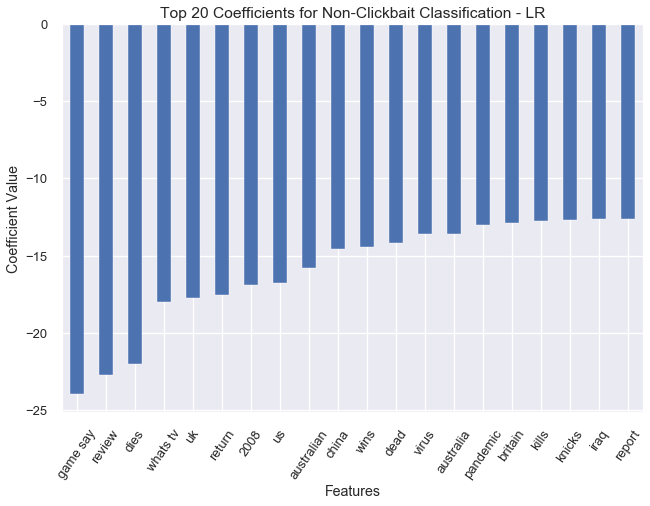

In [66]:
#logistic regression interpretation 

#lr.coef_

#creating dataframe for SVM coefficients to evaluate the highest coefficients
coef_lr = pd.DataFrame(lr.coef_)
#coef_svm.sort_values(by=0,ascending=False).head(20)
coef_df_lr=coef_lr.T
coef_df_lr['tokens']=all_feat_names_2

coef_df_lr.set_index('tokens',inplace=True)

#plot non-cb 
coef_df_lr[0].sort_values(ascending=True).head(20).plot(kind='bar')
plt.title("Top 20 Coefficients for Non-Clickbait Classification - LR")
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=55)
plt.savefig('noncb_lr_coeff')
plt.show()

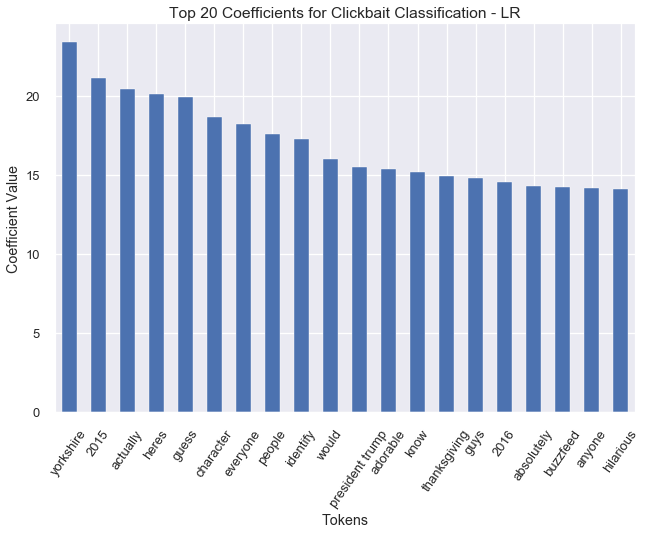

In [67]:
#plot CB classification
coef_df_lr[0].sort_values(ascending=False).head(20).plot(kind='bar')
plt.title("Top 20 Coefficients for Clickbait Classification - LR")
plt.xlabel('Tokens')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=55)
plt.show()

## Conclusion & Next Steps

I was able to use machine learning algorithms such as Naive Bayes, Logistic regression and SVM to accurately classify clickbait versus non-clickbait headlines. The results were quite good -  within the 90-93% range for accuracy scores and 90-93% range for recall scores. I slightly prioritized recall as I figured that it would be more valuable to minimize false negatives (classifying clickbait as non-clickbait).

As machine learning was able to work so well, there is definitely a real world use case for deploying a machine learning solution to filter out / flag clickbait before a reader even has to visualize and discern the headline for themselves! 

By analyzing the coefficients of the models that performed the best, I was able to interpret and get some insight into how the models determined if a headline is clickbait or not. 


#### Next Steps: 
- explore Deep NLP and neural net models to see if they make a stronger classifier 
- set up a front end / app using Flask to predict on new headlines in a current day scenario  
- analyze topics and themes with LDA 
    - possibly use LDA topics for modeling 
- test model on a new dataset